In [17]:
original = True

Solving LP


C:\Users\Bhavik Chandna\AppData\Local\Temp\ipykernel_18504\80051397.py:133: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res=linprog(c,A_ub=A,b_ub=b,bounds=bound)
C:\Users\Bhavik Chandna\AppData\Local\Temp\ipykernel_18504\80051397.py:133: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res=linprog(c,A_ub=A,b_ub=b,bounds=bound)
C:\Users\Bhavik Chandna\AppData\Local\Temp\ipykernel_18504\80051397.py:133: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically c

     con: array([], dtype=float64)
     fun: -5.856133451020168e-09
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([-5.91331411e-11, -6.13490317e-11, -5.73247904e-11, -5.59239797e-11,
       -5.46937310e-11, -5.45820056e-11, -5.64506719e-11, -5.98528283e-11,
       -6.90262849e-11, -6.58654803e-11, -7.06066872e-11, -7.06066872e-11,
       -5.30713531e-11, -5.31314722e-11, -5.30713531e-11, -5.31314722e-11,
       -2.81733953e-11, -3.06754794e-11, -2.76312619e-11, -2.90490793e-11,
       -1.15295411e-10, -1.14507873e-10, -1.15689180e-10, -1.15689180e-10,
       -5.24278373e-11, -5.21401734e-11, -5.43800199e-11, -5.79967212e-11,
       -3.51586628e-11, -3.55491462e-11, -3.57076828e-11, -3.71962064e-11,
       -3.56727427e-11, -3.25119382e-11, -3.72531450e-11, -3.72531450e-11,
       -4.01962925e-11, -3.79804019e-11, -3.94958872e-11, -3.58791858e-11,
        1.76424144e-11,  2.06894752e-11,  1.61188840e-11,  1.61188840e-11,
       -6.42628506e-11, -6.35192900

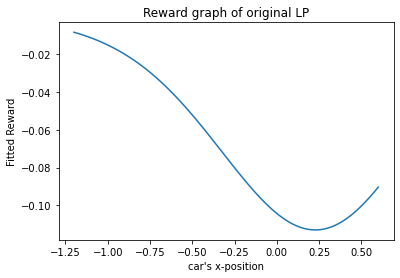

In [18]:
import pickle,random
import numpy as np
import gym
from scipy.optimize import linprog
from math import exp,pi,sqrt
import matplotlib.pyplot as plt

#print(env._max_episode_seconds,env._max_episode_steps)
discretization=120
xmin = -1.2
xmax = 0.6
x_binsize=(xmax - xmin)/discretization
#print(xmin,xmax,x_binsize)

vmin = -0.07
vmax = 0.07
v_binsize=(vmax - vmin)/discretization


def calcPDF(a,m,s):
	a=(a-m)/s
	return (exp(-(a)**2/(2))/(sqrt(2*pi)))/s

def getSampleStates(sampleTrajs):
	sample_states_x=[]
	sample_states_v=[]
	l=[i for i in range(120)]
	for i in range(sampleTrajs):#50
		k=random.choice(l)
		l.remove(k)
		sample_states_x.append(k)
	l=[i for i in range(120)]
	for i in range(sampleTrajs):#50
		k=random.choice(l)
		l.remove(k)
		sample_states_v.append(k)
	sample_states_x.sort()
	sample_states_v.sort()

	S=[]
	for i in sample_states_x:
		for j in sample_states_v:
			S.append([i,j])
	return S


def getState(s):
	xpos = min(discretization-1,round((s[0]-xmin)/x_binsize))
	vpos = min(discretization-1,round((s[1]-vmin)/v_binsize))
	return [int(xpos),int(vpos)]

def getNextState(s,a):
	x=x_binsize*s[0]+xmin
	v=v_binsize*s[1]+vmin
	#print(x,v)
	env.reset()
	obs,R,done,truncated,info=env.step(a)

	return getState(obs)


random.seed(0)
env=gym.make('MountainCar-v0')
#env.seed(1)



f = open('Data\Q_Opt1','rb')
Q=pickle.load(f)
f.close()

#print(Q)
numOfBasis=26
scale=0.5
basis_bin=(0.5+1.2)/(numOfBasis-1)
basis=[-1.2+basis_bin*i for i in range(numOfBasis-1)]+[0.5]
#print(basis)
#value_funcs=[]


#for i in range(1,numOfBasis):
#	calcValueFunc.getFunction(Q,basis[i],scale,i)


V=[]
for i in range(numOfBasis):
	f = open('Data\V'+str(i),'rb')
	V.append(pickle.load(f))
	f.close()
#print(len(value_funcs[0][0]))

kk=50
if original:
	kk=10
S0=getSampleStates(kk)
# print(len(S0))

alphas=None
if original:
	c = [0]*numOfBasis + [-1]*len(S0)
	bound=[(-1,1) for i in range(numOfBasis)] + [(None,None) for j in range(len(S0))]
	A = [[0 for i in range(len(c))] for j in range(4*len(S0))] #list(np.zeros((len(S0)*2,len(c))))
	b =	[0 for j in range(4*len(S0))]

	for i in range(len(S0)):
		A[4*i][numOfBasis+i]=1
		A[4*i+1][numOfBasis+i]=1
		A[4*i+2][numOfBasis+i]=1
		A[4*i+3][numOfBasis+i]=1

		a=np.argmax(np.array(Q[S0[i][0]][S0[i][1]]))
		actions=[0,1,2]
		actions.remove(a)
		a2=actions[0]
		a3=actions[1]

		s=getNextState(S0[i],a)
		s2=getNextState(S0[i],a2)
		s3=getNextState(S0[i],a3)
		
		fact=3
		for j in range(numOfBasis):
			A[4*i][j] = (-1*V[j][s[0]][s[1]] + V[j][s2[0]][s2[1]])/10000
			A[4*i+1][j] = fact*(-1*V[j][s[0]][s[1]] + V[j][s2[0]][s2[1]])/10000
			A[4*i+2][j] = (-1*V[j][s[0]][s[1]] + V[j][s3[0]][s3[1]])/10000
			A[4*i+3][j] = fact*(-1*V[j][s[0]][s[1]] + V[j][s3[0]][s3[1]])/10000


		#print(s,s2,s3)

	#print(A)
	print("Solving LP")
	res=linprog(c,A_ub=A,b_ub=b,bounds=bound)
	# f=open('result','wb')
	# pickle.dump(res,f)
	# f.close()
	print(res)
	alphas=list(res['x'])
	alphas=alphas[:numOfBasis]
	print(alphas)
	#exit(0)
else:
	c = [0]*(numOfBasis)
	bound=[(-1,1) for i in range(numOfBasis)]

	for i in range(len(S0)):

		a=np.argmax(np.array(Q[S0[i][0]][S0[i][1]]))
		actions=[0,1,2]
		actions.remove(a)
		r=random.randint(0,1)
		a2=actions[r]

		s=getNextState(S0[i],a)
		s2=getNextState(S0[i],a2)
		
		for j in range(numOfBasis):
			tmpV= -1*V[j][s[0]][s[1]] + V[j][s2[0]][s2[1]]
			if tmpV>0:
				tmpV*=1.85 #1.85
			c[j] += tmpV
			
		#print(s,s2,s3)

	print(c)
	print("Solving LP")
	res=linprog(c,bounds=bound)
	print(res)
	alphas=res['x']

X=[]
R=[]
x=xmin
std=0.15
if original:
	std=0.5
while x<=xmax:
	X.append(x)
	rx=0
	for k in range(len(basis)):
		rx+= alphas[k]*calcPDF(x,basis[k],std) 
	R.append(rx)

	x+=x_binsize


plt.figure(1)
plt.xlabel("car's x-position")
plt.ylabel("Fitted Reward")

if original:
	plt.title("Reward graph of original LP")
else:
	plt.title("Reward graph of modified LP")
plt.plot(X,R)
plt.show()
